In [60]:
# Figure 1 

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
# meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

# hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
# metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub_LQ <- fread('metadata_subsample_LQ.txt', sep='\t') # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ.txt', sep='\t') # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ[, c('Cell', 'Percent.Mitochondria', 'nCount_RNA', 'nFeature_RNA', 'Annotation', 'Celltype', 'hpca')], 
meta_sub_LQ[, c('Cell', 'nCount_RNA', 'nFeature_RNA', 'Percent.Mitochondria', 'hpca') ])


# initially, hpca labels are used for lineage annotations 
meta_sub[["Lineage"]] <- meta_sub$hpca
meta_sub <- meta_sub %>% mutate( Lineage = case_when(
    meta_sub[["hpca"]] == "Epithelial_cells"  ~ 'Epithelial_cells',
    meta_sub[["hpca"]] == "Fibroblasts"  ~ 'Mesenchymal_cells',
    meta_sub[["hpca"]] == "Smooth_muscle_cells"  ~ 'Mesenchymal_cells',
    meta_sub[["hpca"]] == "Endothelial_cells"  ~ 'Mesenchymal_cells',
    meta_sub[["hpca"]] == "Chondrocytes"  ~ 'Mesenchymal_cells',
    meta_sub[["hpca"]] == "Osteoblasts"  ~ 'Mesenchymal_cells',
    meta_sub[["hpca"]] == "T_cells"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "B_cell"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "Macrophage"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "Monocyte"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "NK_cell"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "Neutrophils"  ~ 'Hematopoeitic_cells',
    meta_sub[["hpca"]] == "Platelets"  ~ 'Hematopoeitic_cells',
# overwrite HQ cells according to JF annotations | Only HQ cells have "Celltype" annotaions
    meta_sub[["Celltype"]] == "Cancer cells"  ~ 'Epithelial_cells',
    meta_sub[["Celltype"]] == "Normal epithelial cells"  ~ 'Epithelial_cells',
    meta_sub[["Celltype"]] == "Adipocytes"  ~ 'Mesenchymal_cells',
    meta_sub[["Celltype"]] == "Fibroblasts"  ~ 'Mesenchymal_cells',
    meta_sub[["Celltype"]] == "Endothelial cells"  ~ 'Mesenchymal_cells',
    meta_sub[["Celltype"]] == "Pericytes"  ~ 'Mesenchymal_cells',
    meta_sub[["Celltype"]] == "Macrophages"  ~ 'Hematopoeitic_cells',
    meta_sub[["Celltype"]] == "T cells"  ~ 'Hematopoeitic_cells',
    meta_sub[["Celltype"]] == "B cells"  ~ 'Hematopoeitic_cells'
))

# Optional : Generate a HQ/LQ labels 
meta_sub[["HQ_LQ_annotation"]] <- ifelse(is.na(meta_sub[["Celltype"]]), meta_sub$hpca , meta_sub$Celltype)

meta_sub <- meta_sub %>% mutate( HQ_LQ_annotation = case_when(
        meta_sub[["HQ_LQ_annotation"]] == "Endothelial_cells"  ~ 'Endothelial cells',
        meta_sub[["HQ_LQ_annotation"]] == "T_cells"  ~ 'T cells',
        meta_sub[["HQ_LQ_annotation"]] == "B_cell"  ~ 'B cells',
        meta_sub[["HQ_LQ_annotation"]] == "Macrophage"  ~ 'Macrophages',
        TRUE ~ meta_sub[["HQ_LQ_annotation"]]
))


# # data
# seu <- qread(file = "seu.qs", nthreads = 16)
# meta_sub <- seu@meta.data

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Mesenchymal_cells")
hem.ind <- which(meta_sub$Lineage == "Hematopoeitic_cells")

# cell type based on hpca labels only
# tcell.ind <- which( meta_sub$hpca == "T_cells" )
# bcell.ind <- which( meta_sub$hpca == "B_cell" )
# macro.ind <- which( meta_sub$hpca == "Macrophage")
# fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
# endo.ind <- which( meta_sub$hpca == "Endothelial_cells")

# cell type based on hpca and Celltype labels 
tcell.ind <- which( meta_sub$HQ_LQ_annotation == "T cells" )
bcell.ind <- which( meta_sub$HQ_LQ_annotation == "B cell" )
macro.ind <- which( meta_sub$HQ_LQ_annotation == "Macrophages")
fibro.ind <- which( meta_sub$HQ_LQ_annotation == "Fibroblasts")
endo.ind <- which( meta_sub$HQ_LQ_annotation == "Endothelial cells")

## setting cut-offs
## JF's cut-off for FELINE_C1: > 1500 UMI. 500 - 7000 genes 
Total.Reads_cutoff <- 1500
new.Total.Reads_cutoff <- 800
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000

all.disposed <- length(which(meta_sub$Total.Reads < Total.Reads_cutoff)) / length(meta_sub$Total.Reads )
epi.disposed <- length(which(meta_sub$Total.Reads[epi.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[epi.ind] )
mes.disposed <- length(which(meta_sub$Total.Reads[mes.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[mes.ind] )
hem.disposed <- length(which(meta_sub$Total.Reads[hem.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[hem.ind] )

tcell.disposed <- length(which(meta_sub$Total.Reads[tcell.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[tcell.ind] )
macro.disposed <- length(which(meta_sub$Total.Reads[macro.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[macro.ind] )
fibro.disposed <- length(which(meta_sub$Total.Reads[fibro.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[fibro.ind] )
endo.disposed <- length(which(meta_sub$Total.Reads[endo.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[endo.ind] )
bcell.disposed <- length(which(meta_sub$Total.Reads[bcell.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[bcell.ind] )



## uncomment based on desired plot, cell type vs lineage
# retained <- as.data.frame(rbind(c(epi_total, epi_above_nreads, epi_above_nfeatures, epi_retained_reads, epi_retained_genes, 'Epithelial_cells' ),
#                                 c(mes_total, mes_above_nreads, mes_above_nfeatures, mes_retained_reads, mes_retained_genes, 'Mesenchymal_cells' ),
#                                 c(hem_total, hem_above_nreads, hem_above_nfeatures, hem_retained_reads, hem_retained_genes, 'Hematopoeitic_cells' )
#                                 # c(tcell_total, tcell_above_nreads, tcell_above_nfeatures, tcell_retained_reads, tcell_retained_genes, 'T_cells' ),
#                                 # c(macro_total, macro_above_nreads, macro_above_nfeatures, macro_retained_reads, macro_retained_genes, 'Macrophage' ),
#                                 # c(fibro_total, fibro_above_nreads, fibro_above_nfeatures, fibro_retained_reads, fibro_retained_genes, 'Fibroblasts' ),
#                                 # c(Bcell_total, Bcell_above_nreads, Bcell_above_nfeatures, Bcell_retained_reads, Bcell_retained_genes, 'B_cell' )
#                                 ))
# colnames(retained) <- c('Total_cells', 'Cells_filtered_by_reads', 'Cells _filtered_by_genes', 'pct_retained_reads_filter', 'pct_retained_genes_filter', 'type')

# retained_sorted <-
#   retained %>%
#   mutate(type = fct_reorder(type, desc(pct_retained_reads_filter)))



In [9]:

options(repr.plot.width=14, repr.plot.height=6)

# pre.retained.epi <- length(which(meta_sub$Total.Reads[epi.ind] > Total.Reads_cutoff))
# post.retained.epi <- length(which(meta_sub$Total.Reads[epi.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[epi.ind] > new.Total.Reads_cutoff))

# pre.retained.tcell <- length(which(meta_sub$Total.Reads[tcell.ind] > Total.Reads_cutoff))
# post.retained.tcell <- length(which(meta_sub$Total.Reads[tcell.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[tcell.ind] > new.Total.Reads_cutoff))

# pre.retained.macro <- length(which(meta_sub$Total.Reads[macro.ind] > Total.Reads_cutoff))
# post.retained.macro <- length(which(meta_sub$Total.Reads[macro.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[macro.ind] > new.Total.Reads_cutoff))

# pre.retained.fibro <- length(which(meta_sub$Total.Reads[fibro.ind] > Total.Reads_cutoff))
# post.retained.fibro <- length(which(meta_sub$Total.Reads[fibro.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[fibro.ind] > new.Total.Reads_cutoff))
## Plot number of reads and genes by Cell type. Epithelial cells are used as a reference 

par(mfrow=c(2,5), mar=c(6,5,5,1))
plot(main = "All cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*all.disposed),'%' ), density(log10(meta_sub$Total.Reads)), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "Epithelial cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*epi.disposed),'%' ), density(log10(meta_sub$Total.Reads[epi.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "Mesenchymal cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*mes.disposed),'%' ), density(log10(meta_sub$Total.Reads[mes.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "Hematopoeitic cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*hem.disposed),'%' ), density(log10(meta_sub$Total.Reads[hem.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")

plot(main = "Fibroblasts: total reads (log10)", sub = paste('pct cells disposed:', round(100*fibro.disposed ),'%' ), density(log10(meta_sub$Total.Reads[fibro.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "Endothelial cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*endo.disposed ),'%' ), density(log10(meta_sub$Total.Reads[endo.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "B.cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*bcell.disposed ),'%' ), density(log10(meta_sub$Total.Reads[bcell.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "T.cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*tcell.disposed ),'%' ), density(log10(meta_sub$Total.Reads[tcell.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")
plot(main = "Macrophages: total reads (log10)", sub = paste('pct cells disposed:', round(100*macro.disposed ),'%' ), density(log10(meta_sub$Total.Reads[macro.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred")





options(repr.plot.width=6, repr.plot.height=6)

ggplot(retained_sorted, aes(as.factor(type), round(as.numeric(pct_retained_reads_filter), 2), fill = as.factor(type) )) + 
geom_bar(stat = "identity") + 
xlab ('Lineage') + 
ylab ('% retained after UMI filter')

# plot(main = "Epithelial cells: expressed genes (log10)",density(log10(meta_sub$Expressed.Features[epi.ind])), cex.main = 1); abline(v=log10(Expressed.Features_cutoff.min), lty=2, col="darkred"); abline(v=log10(Expressed.Features_cutoff.max), lty=2, col="darkred")
# plot(main = "T.cells: expressed genes (log10)",density(log10(meta_sub$Expressed.Features[tcell.ind])), cex.main = 1); abline(v=log10(Expressed.Features_cutoff.min), lty=2, col="darkred"); abline(v=log10(Expressed.Features_cutoff.max), lty=2, col="darkred")
# plot(main = "Macrophages: expressed genes (log10)", density(log10(meta_sub$Expressed.Features[macro.ind])), cex.main = 1); abline(v=log10(Expressed.Features_cutoff.min), lty=2, col="darkred"); abline(v=log10(Expressed.Features_cutoff.max), lty=2, col="darkred")
# plot(main = "Fibroblasts: expressed genes (log10)", density(log10(meta_sub$Expressed.Features[fibro.ind])), cex.main = 1); abline(v=log10(Expressed.Features_cutoff.min), lty=2, col="darkred"); abline(v=log10(Expressed.Features_cutoff.max), lty=2, col="darkred")



ERROR: Error in log10(meta_sub$Total.Reads): non-numeric argument to mathematical function


ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


In [61]:
unique(meta_sub[["HQ_LQ_annotation"]])
unique(meta_sub[ mes.ind,]$HQ_LQ_annotation )
unique(meta_sub[ epi.ind,]$HQ_LQ_annotation )

[1] "Fibroblasts"             "Cancer cells"           
 [3] "Endothelial cells"       "Adipocytes"             
 [5] "Normal epithelial cells" "Pericytes"              
 [7] "T cells"                 "Macrophages"            
 [9] "B cells"                 "iPS_cells"              
[11] "Osteoblasts"             "Neutrophils"            
[13] "Hepatocytes"             "Embryonic_stem_cells"   
[15] "DC"                      "NK_cell"                
[17] "Platelets"               "Tissue_stem_cells"      
[19] "Gametocytes"             "Epithelial_cells"       
[21] "Smooth_muscle_cells"     "Astrocyte"              
[23] "HSC_-G-CSF"              "Erythroblast"           
[25] "Chondrocytes"            "Neurons"                
[27] "Keratinocytes"           "Neuroepithelial_cell"   
[29] "Monocyte"                "MSC"                    
[31] "HSC_CD34+"               "CMP"                    
[33] "Pre-B_cell_CD34-"        "BM"                     
[35] "Pro-B_cell_CD34+"        "MEP"                    
[37] "Myelocyte"               "Pro-Myelocyte"          
[39] "BM_&_Prog."

[1] "Fibroblasts"             "Endothelial cells"      
 [3] "Adipocytes"              "Pericytes"              
 [5] "Cancer cells"            "Normal epithelial cells"
 [7] "Macrophages"             "Osteoblasts"            
 [9] "Smooth_muscle_cells"     "Chondrocytes"

[1] "Cancer cells"            "Normal epithelial cells"
[3] "Fibroblasts"             "Macrophages"            
[5] "Epithelial_cells"

Picking joint bandwidth of 326

Warning message:
"Removed 1212 rows containing non-finite values (stat_density_ridges)."
Picking joint bandwidth of 420

Warning message:
"Removed 188 rows containing non-finite values (stat_density_ridges)."


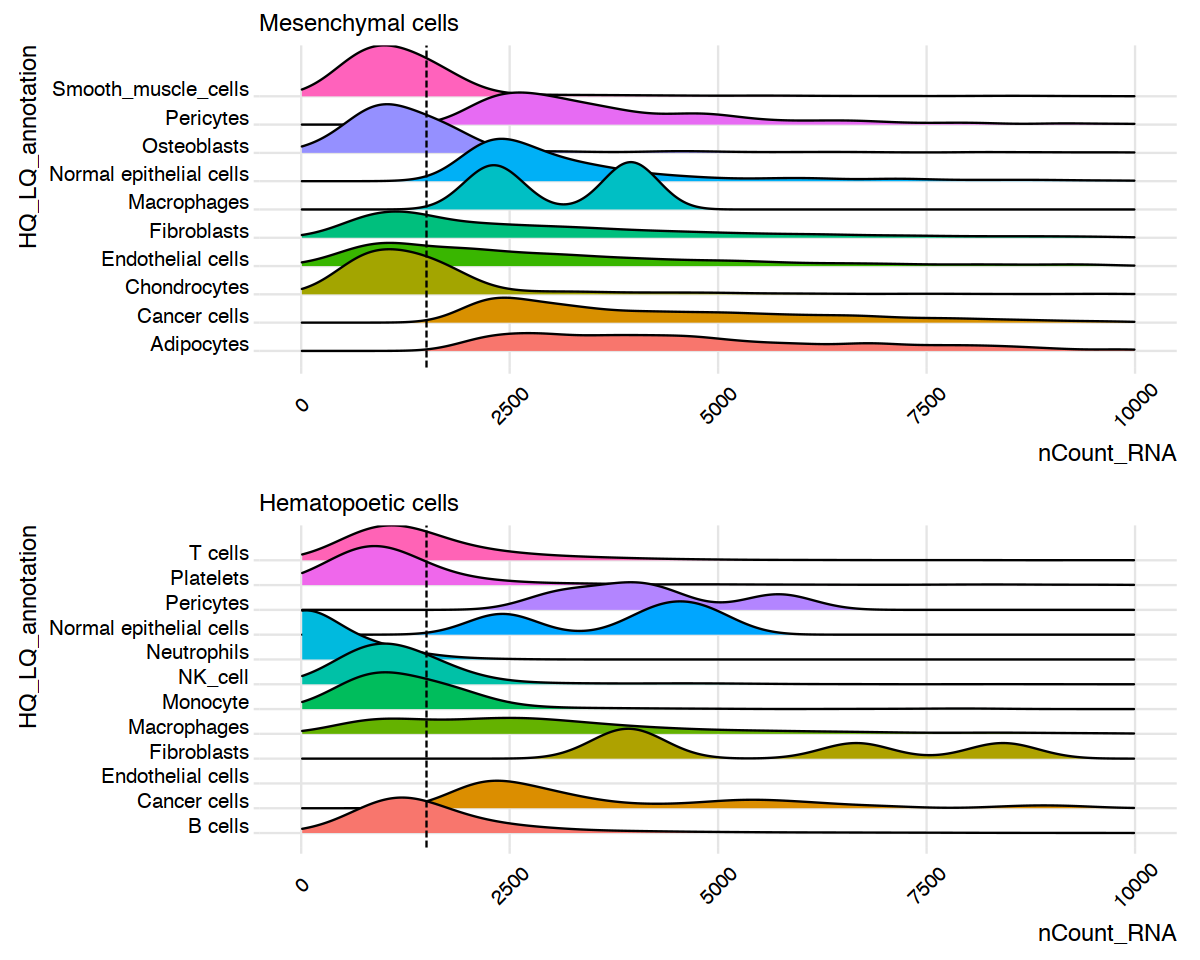

In [55]:
options(repr.plot.width=10, repr.plot.height=8)

plot1 <- ggplot(meta_sub[mes.ind,], aes(x = nCount_RNA, y = HQ_LQ_annotation, fill = HQ_LQ_annotation)) +
            geom_density_ridges() +
            theme_ridges() + 
            ggtitle("Mesenchymal cells")+
            geom_vline(xintercept = Total.Reads_cutoff, linetype = "longdash") +
            xlim(0, 10000) +
            theme(legend.position = "none", axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))



plot2 <- ggplot(meta_sub[hem.ind,], aes(x = nCount_RNA, y = HQ_LQ_annotation, fill = HQ_LQ_annotation)) +
            geom_density_ridges() +
            theme_ridges() + 
            ggtitle("Hematopoetic cells")+
            geom_vline(xintercept = Total.Reads_cutoff, linetype = "longdash") +
            xlim(0, 10000) +
            theme(legend.position = "none", axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))

# plot3 <- ggplot(meta_sub[mes.ind,], aes(x = nFeature_RNA, y = hpca, fill = hpca)) +
#             geom_density_ridges() +
#             theme_ridges() + 
#             ggtitle("Mesenchymal cells")+
#             geom_vline(xintercept = 500, linetype = "longdash") +
#             xlim(0, 8000) +
#             theme(legend.position = "none", axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))

# plot4 <- ggplot(meta_sub[hem.ind,], aes(x = nFeature_RNA, y = hpca, fill = hpca)) +
#             geom_density_ridges() +
#             theme_ridges() + 
#             ggtitle("Hematopoetic cells")+
#             geom_vline(xintercept = 500, linetype = "longdash") +
#             xlim(0, 8000) +
#             theme(legend.position = "none", axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))


ggarrange(grobs = plot1, plot2, ncol=1, nrow=2, heights=c(200,200), widths = c(100,100)) #common.legend = TRUE, legend="bottom")


In [ ]:
###################################################################################################################

In [ ]:
# Figure 2

setwd('/Users/ibishara/Desktop/FELINE_C1/downsample/')

# packages
library(data.table)
library(ggridges)
library(ggpubr)
library(stringr)

# data
summ <- fread('performance_summary_400_400cells.txt', sep = '\t') 

dist.lineage <- fread( 'lineage_distributions_by_condition.txt', sep = '\t') 
dist.lineage$V1 <- NULL
dist.lineage <- melt(dist.lineage)
dist.lineage[["class"]] <- 'Lineage'

dist.celltype <- fread('celltype_distributions_by_condition.txt', sep = '\t') 
dist.celltype$V1 <- NULL
dist.celltype <- melt(dist.celltype)
dist.celltype[["class"]] <- 'Celltype'

dist <- rbind(dist.lineage, dist.celltype)
dist$value <- dist$value/1000
dist[["threshold"]] <- str_sub(dist$variable, -3, -1)
dist[["source"]] <- str_sub(dist$variable, -14, -10)
dist[["method"]] <- str_sub(dist$variable, -25, -16)


Warning message in fread("performance_summary_400_400cells.txt", sep = "\t"):
"Detected 8 column names but the data has 9 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread("lineage_distributions_by_condition.txt", sep = "\t"):
"Detected 31 column names but the data has 32 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in melt.data.table(dist.lineage):
"id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns []. C

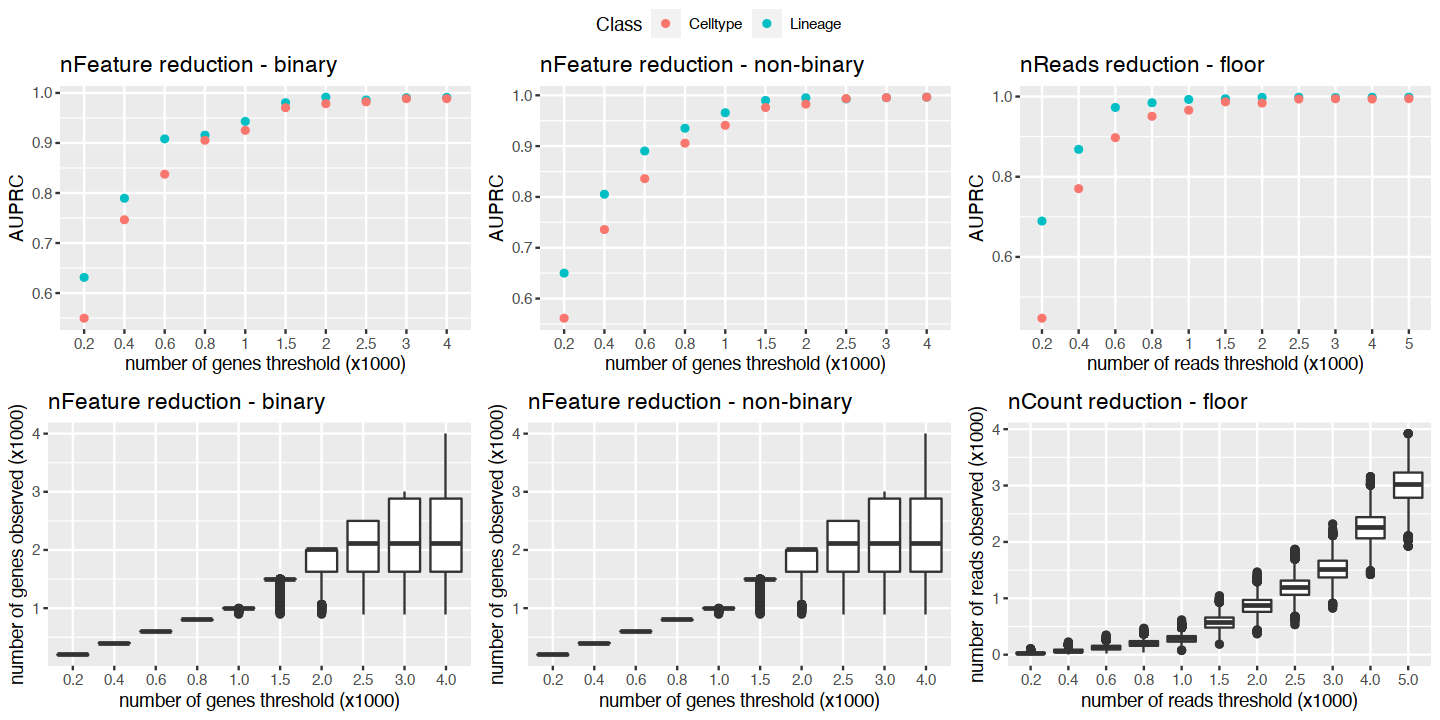

In [ ]:

options(repr.plot.width=12, repr.plot.height=6)


# pdf('performance_summary_400_400cells.pdf')

        #Genes binary 
plot1 <-
ggplot(summ[summ$source == 'genes' & summ$method == 'binar',], aes(as.factor(threshold), as.numeric(AUC)  )) + 
        geom_point(aes(color = as.factor(class.var))) + 
        ggtitle("nFeature reduction - binary") +
        xlab("number of genes threshold (x1000)") + ylab("AUPRC")+ labs(color='Class') 

plot2 <-
ggplot(dist[dist$source == 'genes' & dist$method == 'binary',], aes(as.factor(threshold), value)) + 
        geom_boxplot() + 
        ggtitle("nFeature reduction - binary") +
        xlab('number of genes threshold (x1000)') + ylab("number of genes observed (x1000)")



        #Genes non-binary
plot3 <-
ggplot(summ[summ$source == 'genes' & summ$method == 'nonbi',], aes(as.factor(threshold), as.numeric(AUC)  )) + 
        geom_point(aes(color = as.factor(class.var))) + 
        ggtitle("nFeature reduction - non-binary") +
        xlab("number of genes threshold (x1000)") + ylab("AUPRC")+ labs(color='Class') 

plot4 <-
ggplot(dist[dist$source == 'genes' & dist$method == 'non-binary',], aes(as.factor(threshold), value)) + 
        geom_boxplot() + 
        ggtitle("nFeature reduction - non-binary") +
        xlab('number of genes threshold (x1000)') + ylab("number of genes observed (x1000)")


        #Reads floor
plot5 <-
ggplot(summ[summ$source == 'reads' & summ$method == 'floor',], aes(as.factor(threshold), as.numeric(AUC)  )) + 
        geom_point(aes(color = as.factor(class.var))) + 
        ggtitle("nReads reduction - floor") +
        xlab("number of reads threshold (x1000)") + ylab("AUPRC")+ labs(color='Class') 

plot6 <-
ggplot(dist[dist$source == 'reads' & dist$method == 'floor',], aes(as.factor(threshold), value)) + 
        geom_boxplot() + 
        ggtitle("nCount reduction - floor") +
        xlab('number of reads threshold (x1000)') + ylab("number of reads observed (x1000)")


        ggarrange(grobs = plot1, plot3, plot5, plot2, plot4, plot6, ncol=3, nrow=2, heights=c(200, 200, 200), widths = c(200,200), common.legend = TRUE) #common.legend = TRUE, legend="bottom")

#dev.off()


In [ ]:
###############################################################################################################################################

In [ ]:
# Figure 3

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub <- read.table('metadata_subsample_cell_quality.txt', sep='\t') # subsample metadata


# # data
seu <- qread(file = "seu.qs", nthreads = 16)
meta_sub <- seu@meta.data

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Mesenchymal_cells")
hem.ind <- which(meta_sub$Lineage == "Hematopoeitic_cells")

# cell type
tcell.ind <- which( meta_sub$hpca == "T_cells" )
bcell.ind <- which( meta_sub$hpca == "B_cell" )
macro.ind <- which( meta_sub$hpca == "Macrophage")
fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
endo.ind <- which( meta_sub$hpca == "Endothelial_cells")
bcell.ind <- which( meta_sub$hpca == "B_cell")



## setting cut-offs
## JF's cut-off for FELINE_C1: > 2000 UMI. 500 - 7000 genes 
Total.Reads_cutoff <- 1500
new.Total.Reads_cutoff <- 800
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000



all.disposed <- length(which(meta_sub$Total.Reads < Total.Reads_cutoff)) / length(meta_sub$Total.Reads )
epi.disposed <- length(which(meta_sub$Total.Reads[epi.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[epi.ind] )
mes.disposed <- length(which(meta_sub$Total.Reads[mes.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[mes.ind] )
hem.disposed <- length(which(meta_sub$Total.Reads[hem.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[hem.ind] )

tcell.disposed <- length(which(meta_sub$Total.Reads[tcell.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[tcell.ind] )
macro.disposed <- length(which(meta_sub$Total.Reads[macro.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[macro.ind] )
fibro.disposed <- length(which(meta_sub$Total.Reads[fibro.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[fibro.ind] )
endo.disposed <- length(which(meta_sub$Total.Reads[endo.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[endo.ind] )
bcell.disposed <- length(which(meta_sub$Total.Reads[bcell.ind] < Total.Reads_cutoff)) / length(meta_sub$Total.Reads[bcell.ind] )


Warning message in fread("/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt", :
"Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


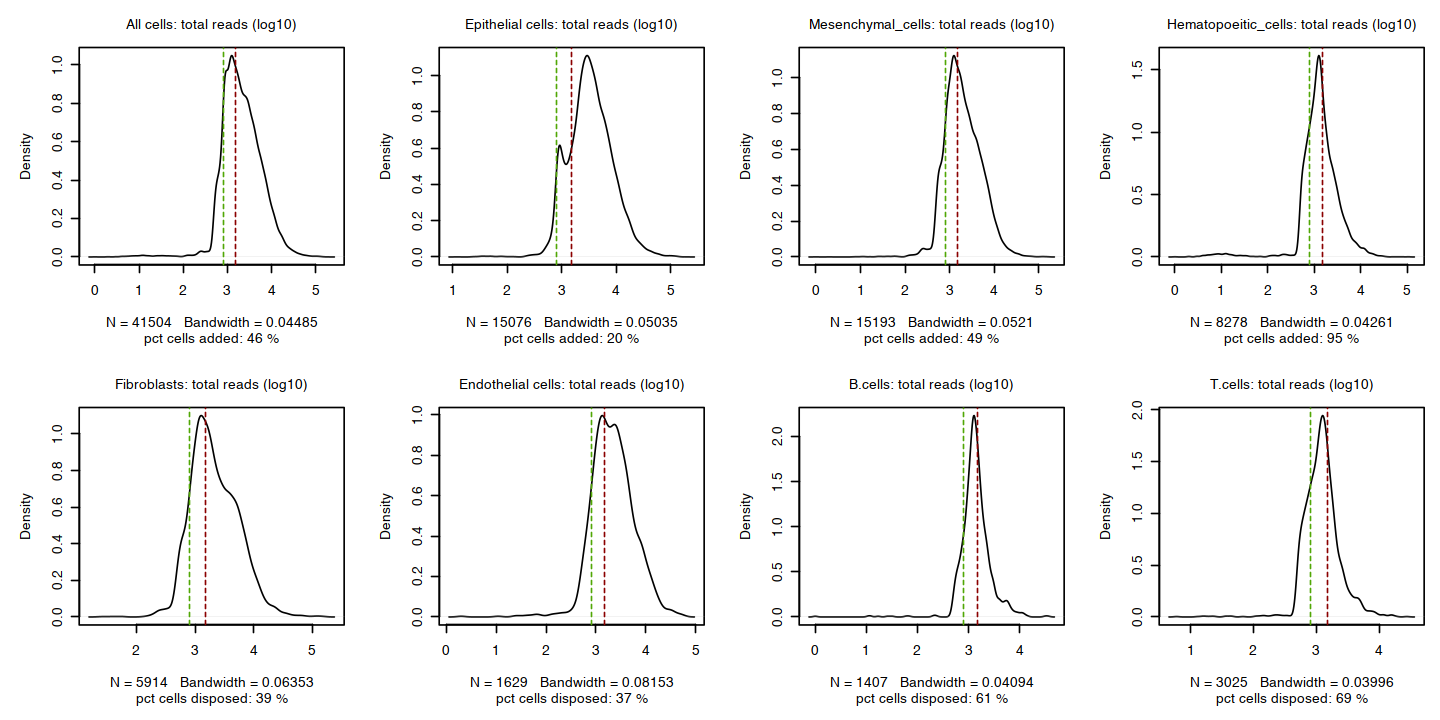

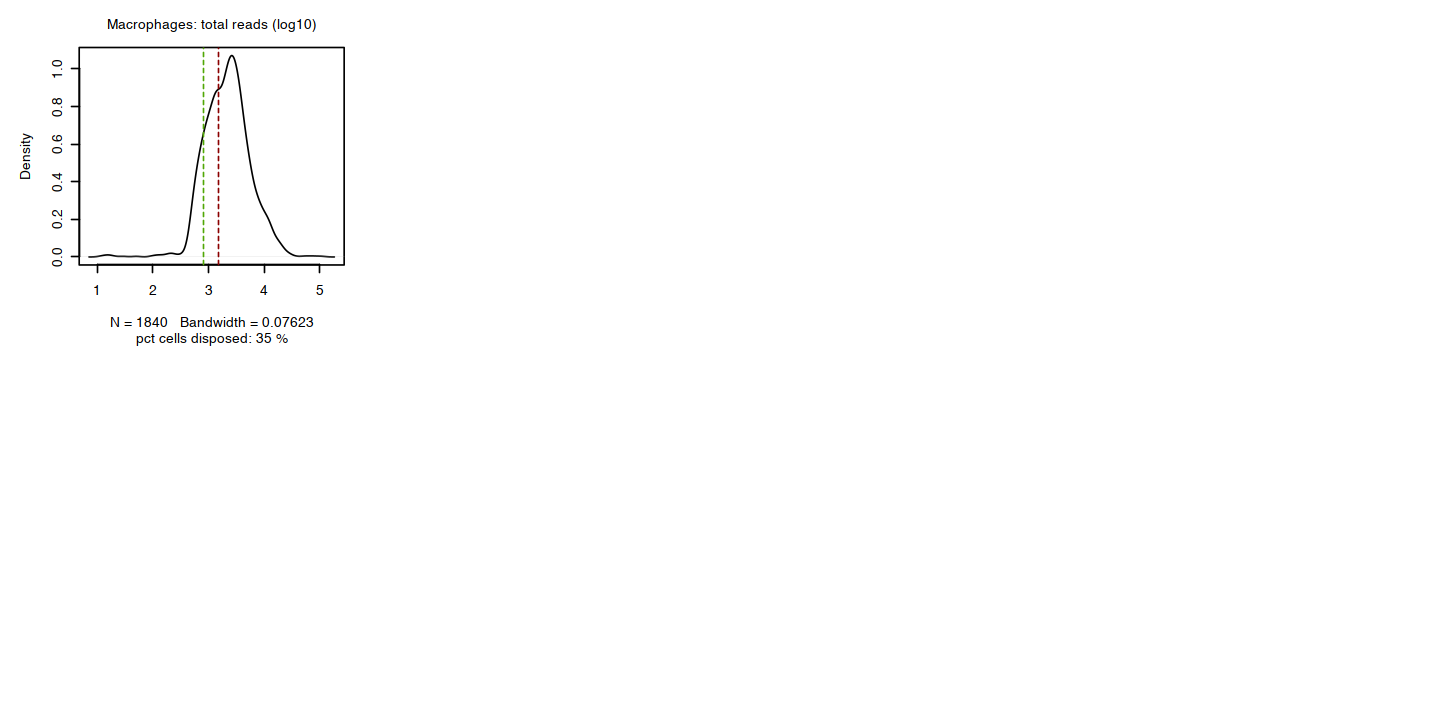

In [ ]:

options(repr.plot.width=12, repr.plot.height=6)

pre.retained.all <- length(which(meta_sub$Total.Reads > Total.Reads_cutoff))
post.retained.all <- length(which(meta_sub$Total.Reads < Total.Reads_cutoff & meta_sub$Total.Reads > new.Total.Reads_cutoff))

pre.retained.epi <- length(which(meta_sub$Total.Reads[epi.ind] > Total.Reads_cutoff))
post.retained.epi <- length(which(meta_sub$Total.Reads[epi.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[epi.ind] > new.Total.Reads_cutoff))

pre.retained.mes <- length(which(meta_sub$Total.Reads[mes.ind] > Total.Reads_cutoff))
post.retained.mes <- length(which(meta_sub$Total.Reads[mes.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[mes.ind] > new.Total.Reads_cutoff))

pre.retained.hem <- length(which(meta_sub$Total.Reads[hem.ind] > Total.Reads_cutoff))
post.retained.hem <- length(which(meta_sub$Total.Reads[hem.ind] < Total.Reads_cutoff & meta_sub$Total.Reads[hem.ind] > new.Total.Reads_cutoff))

## Plot number of reads and genes by lineage
par(mfrow=c(2,4), mar=c(6,5,3,1))
plot(main = "All cells: total reads (log10)", sub = paste('pct cells added:', round(100*post.retained.all/pre.retained.all),'%' ), density(log10(meta_sub$Total.Reads)), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "Epithelial cells: total reads (log10)", sub = paste('pct cells added:', round(100*post.retained.epi/pre.retained.epi),'%' ), density(log10(meta_sub$Total.Reads[epi.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "Mesenchymal_cells: total reads (log10)", sub = paste('pct cells added:', round(100*post.retained.mes/pre.retained.mes),'%' ), density(log10(meta_sub$Total.Reads[mes.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "Hematopoeitic_cells: total reads (log10)", sub = paste('pct cells added:', round(100*post.retained.hem/pre.retained.hem),'%' ), density(log10(meta_sub$Total.Reads[hem.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")

plot(main = "Fibroblasts: total reads (log10)", sub = paste('pct cells disposed:', round(100*fibro.disposed ),'%' ), density(log10(meta_sub$Total.Reads[fibro.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "Endothelial cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*endo.disposed ),'%' ), density(log10(meta_sub$Total.Reads[endo.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "B.cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*bcell.disposed ),'%' ), density(log10(meta_sub$Total.Reads[bcell.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "T.cells: total reads (log10)", sub = paste('pct cells disposed:', round(100*tcell.disposed ),'%' ), density(log10(meta_sub$Total.Reads[tcell.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")
plot(main = "Macrophages: total reads (log10)", sub = paste('pct cells disposed:', round(100*macro.disposed ),'%' ), density(log10(meta_sub$Total.Reads[macro.ind])), cex.main = 1); abline(v=log10(Total.Reads_cutoff), lty=2, col="darkred"); abline(v=log10(new.Total.Reads_cutoff), lty=2, col="#51a706")

# dev.off()


